In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import itertools

from bussilab.ann import ANN
from bussilab.ann import _softplus as softplus
from bussilab.ann import _sigmoid as sigmoid

In [2]:
np.random.seed(1977)

# Fitting XOR function with a neural network

This is a simple and known case where a linear function is not sufficient. I make some test below.

Don't take it too seriously. Minimization is done with a straightforward L-BFGS. No regularization is used. It's mostly to see if minimizations work.

Before starting I define some tool.

In [3]:
# Function generating a random set of data points
def random_data(nfeatures,nsamples):
    return np.array(np.random.randint(2,size=(nsamples,nfeatures)),dtype=float)

In [4]:
# Function enumerating all the possible data points
def enumerate_data(nfeatures):
    return np.array([list(i) for i in itertools.product([0, 1], repeat=nfeatures)],dtype=float)

In [5]:
# XOR function
def xor(samples):
    return np.array(np.sum(samples,axis=1)%2,dtype=float)

In [6]:
# Print confusion matrix
def confusion_matrix(ref,predict):
    print("confusion matrix:")
    TP=np.sum(np.logical_and(ref>0.5,predict>0.5))
    FP=np.sum(np.logical_and(ref<0.5,predict>0.5))
    FN=np.sum(np.logical_and(ref>0.5,predict<0.5))
    TN=np.sum(np.logical_and(ref<0.5,predict<0.5))
    print("TP",TP)
    print("FP",FP)
    print("FN",FN)
    print("TN",TN)
    print("MCC",(TP*TN-FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)))

In [7]:
# Compute MCC
def MCC(ref,predict):
    TP=np.sum(np.logical_and(ref>0.5,predict>0.5))
    FP=np.sum(np.logical_and(ref<0.5,predict>0.5))
    FN=np.sum(np.logical_and(ref>0.5,predict<0.5))
    TN=np.sum(np.logical_and(ref<0.5,predict<0.5))
    return (TP*TN-FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))

In [8]:
# loss function
def function(x,ann,samples,labels,reg=0.0):
    ann.setpar(x)
    f=ann.derparVec(samples)
    loss=0
    dloss=np.zeros(ann.npar)
    loss=np.sum(softplus(f[0]*(1-2*labels)))
    dloss=np.matmul(f[1].T*(1-2*labels),sigmoid(f[0]*(1-2*labels)))
    loss/=len(samples)
    dloss/=len(samples)
    loss+=0.5*reg*np.sum(x[:ann.nparW]**2)
    dloss[:ann.nparW]+=reg*x[:ann.nparW]
    return loss,dloss

In [9]:
# print a set of data and labels with pandas
def to_pandas(data,labels):
    df=pd.DataFrame(np.vstack((data.T,labels)).T)
    columns={}
    for i in range(data.shape[1]):
        columns[i]="v"+str(i+1)
    columns[data.shape[1]]="label"
    df=df.rename(columns=columns)
    return df

## Simple XOR (2 inputs)
First I do a simple test with 2 features. The function that I want to fit has this form

In [10]:
data=enumerate_data(2)
labels=xor(data)
to_pandas(data,labels)

,v1,v2,label
0,0.0,0.0,0.0
1,0.0,1.0,1.0
2,1.0,0.0,1.0
3,1.0,1.0,0.0


In [11]:
# Create a neural network with a hidden layer
np.random.seed(1977)
ann=ANN([2,2],random_weights=True)
print(ann.npar)

9


In [12]:
m=minimize(function,ann.getpar(),args=(ann,data,labels),jac=True,method='L-BFGS-B')

In [13]:
m

      fun: 7.756714568907734e-06
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.40980938e-09, -2.24247548e-60,  2.44496266e-24, -3.73314744e-24,
       -1.20660671e-10, -1.80610430e-24,  5.40980938e-09, -3.73314744e-24,
       -7.75659424e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 47
      nit: 37
     njev: 47
   status: 0
  success: True
        x: array([-39.7939478 , -80.01996576,  20.81215892,  82.90679882,
       -44.83525081,  68.45773319,  28.72288391, -49.78680876,
        10.38133927])

I then test the prediction on the enumeration of all states

In [14]:
ann.setpar(m.x)
to_pandas(data,sigmoid(ann.applyVec(data)))

,v1,v2,label
0,0.0,0.0,0.000000e+00
1,0.0,1.0,1.000000e+00
2,1.0,0.0,9.999690e-01
3,1.0,1.0,6.787556e-186


In [15]:
confusion_matrix(xor(data),sigmoid(ann.applyVec(data)))

confusion matrix:
TP 2
FP 0
FN 0
TN 2
MCC 1.0


For comparison I can try without hidden layers (a linear model).

In [16]:
np.random.seed(1977)
ann=ANN([2],random_weights=True)
m=minimize(function,ann.getpar(),args=(ann,data,labels),jac=True,method='L-BFGS-B')
print(m)
ann.setpar(m.x)


      fun: 0.6931471805803846
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.64085643e-06, 1.27680647e-06, 7.50758938e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 10
      nit: 9
     njev: 10
   status: 0
  success: True
        x: array([ 2.02476313e-05,  1.44228320e-05, -1.43321959e-05])


In [17]:
to_pandas(data,sigmoid(ann.applyVec(data)))

,v1,v2,label
0,0.0,0.0,0.499996
1,0.0,1.0,0.500000
2,1.0,0.0,0.500001
3,1.0,1.0,0.500005


In [18]:
confusion_matrix(xor(data),sigmoid(ann.applyVec(data)))

confusion matrix:
TP 2
FP 1
FN 0
TN 1
MCC 0.5773502691896258


As expected it does not work.

## Higher dimensional input

I now try to make it more complicated using a higher dimensional input

In [19]:
data=enumerate_data(3)
labels=xor(data)
to_pandas(data,labels)

,v1,v2,v3,label
0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0
2,0.0,1.0,0.0,1.0
3,0.0,1.0,1.0,0.0
4,1.0,0.0,0.0,1.0
5,1.0,0.0,1.0,0.0
6,1.0,1.0,0.0,0.0
7,1.0,1.0,1.0,1.0


In [20]:
np.random.seed(1977)
ann=ANN([3,3],random_weights=True)
print(ann.npar)
m=minimize(function,ann.getpar(),args=(ann,data,labels),jac=True,method='L-BFGS-B')
print(m)
ann.setpar(m.x)

16
      fun: 0.28116778509019663
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.49616717e-15,  9.29759693e-08,  2.14210670e-08, -7.22171188e-17,
        5.21738145e-08,  6.66699361e-10,  8.28323277e-28, -4.95254429e-08,
        2.20877664e-08, -2.15516674e-14,  5.23607465e-08,  3.20479310e-10,
        3.50076709e-15,  1.45149784e-07,  2.20877664e-08,  3.26309000e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 78
      nit: 55
     njev: 78
   status: 0
  success: True
        x: array([  1.71673905, -85.1563573 , -67.26520936,  -4.93837536,
       -85.69433872, -70.33917078, -24.15434701,  20.49684691,
       106.74677962,  -0.16238963,  -2.74773255,  69.88008804,
       -29.69859749,  71.6995034 , -43.02444598,   1.09864846])


In [21]:
to_pandas(data,sigmoid(ann.applyVec(data)))

,v1,v2,v3,label
0,0.0,0.0,0.0,8.247473e-86
1,0.0,0.0,1.0,1.000000e+00
2,0.0,1.0,0.0,7.500064e-01
3,0.0,1.0,1.0,5.713510e-08
4,1.0,0.0,0.0,7.500060e-01
5,1.0,0.0,1.0,8.721975e-08
6,1.0,1.0,0.0,7.500068e-01
7,1.0,1.0,1.0,7.500068e-01


In [22]:
confusion_matrix(xor(data),sigmoid(ann.applyVec(data)))

confusion matrix:
TP 4
FP 1
FN 0
TN 3
MCC 0.7745966692414834


Not perfect

# Even higher dimensional input

In [23]:
data=enumerate_data(6)
labels=xor(data)
to_pandas(data,labels)

,v1,v2,v3,v4,v5,v6,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
59,1.0,1.0,1.0,0.0,1.0,1.0,1.0
60,1.0,1.0,1.0,1.0,0.0,0.0,0.0
61,1.0,1.0,1.0,1.0,0.0,1.0,1.0
62,1.0,1.0,1.0,1.0,1.0,0.0,1.0


In [24]:
np.random.seed(1977)
ann=ANN([6,6],random_weights=True)
print(ann.npar)
m=minimize(function,ann.getpar(),args=(ann,data,labels),jac=True,method='L-BFGS-B')
print(m)
ann.setpar(m.x)

49
      fun: 0.6931474351747715
 hess_inv: <49x49 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.25767805e-06, -4.45800023e-08,  6.13219662e-07,  1.03915614e-07,
       -1.77794844e-07,  8.99210181e-07,  2.62025811e-06,  4.94406872e-08,
        6.42420840e-07,  8.55975430e-08, -1.88820349e-07,  9.58153942e-07,
        5.69402609e-07,  2.08724346e-07,  1.83302302e-07, -7.02755371e-09,
       -3.66108037e-08,  4.15135622e-07,  2.62106876e-07,  3.89269396e-07,
        1.29893821e-07,  2.26738582e-08, -1.75655091e-08,  1.81250708e-08,
       -1.18638837e-07,  3.41322777e-07,  2.38130413e-08, -3.69003295e-08,
        2.44537419e-08,  1.25949625e-07, -1.61842012e-07,  3.42390650e-07,
       -1.03439299e-07, -4.72874342e-08,  5.86713789e-08, -2.92289927e-07,
       -2.54287167e-05, -2.81305810e-06, -3.93753547e-05, -1.71464354e-05,
       -1.19676760e-05, -2.77238404e-05,  1.28032202e-06,  6.39585650e-07,
        2.42900417e-07,  2.05636143e-08, -5.46476564e-08,  3.42171424e-07

In [25]:
to_pandas(data,sigmoid(ann.applyVec(data)))

,v1,v2,v3,v4,v5,v6,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.500108
1,0.0,0.0,0.0,0.0,0.0,1.0,0.499955
2,0.0,0.0,0.0,0.0,1.0,0.0,0.500350
3,0.0,0.0,0.0,0.0,1.0,1.0,0.500539
4,0.0,0.0,0.0,1.0,0.0,0.0,0.500682
...,...,...,...,...,...,...,...
59,1.0,1.0,1.0,0.0,1.0,1.0,0.500206
60,1.0,1.0,1.0,1.0,0.0,0.0,0.499695
61,1.0,1.0,1.0,1.0,0.0,1.0,0.499846
62,1.0,1.0,1.0,1.0,1.0,0.0,0.499309


In [26]:
confusion_matrix(xor(data),sigmoid(ann.applyVec(data)))

confusion matrix:
TP 17
FP 14
FN 15
TN 18
MCC 0.09379580992210836


Here it's not working at all

# Robustness of output

I now check how the result depends on the initial weights. For with the 2 dimension input.

In [27]:
data=enumerate_data(2)
labels=xor(data)
to_pandas(data,labels)

,v1,v2,label
0,0.0,0.0,0.0
1,0.0,1.0,1.0
2,1.0,0.0,1.0
3,1.0,1.0,0.0


In [28]:
res=[]
par=[]
np.random.seed(1977)
for i in range(300):
    ann=ANN([2,2],random_weights=True)
    m=minimize(function,ann.getpar(),args=(ann,data,labels),jac=True,method='L-BFGS-B')
    res.append(m.fun)
    par.append(m.x)

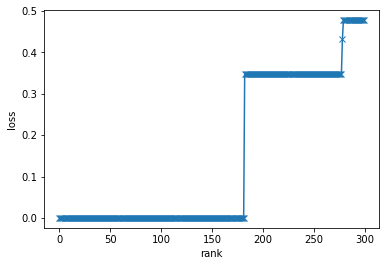

In [29]:
plt.xlabel("rank")
plt.ylabel("loss")
plt.plot(np.sort(res),"x-")

Most of the time it works, but sometimes it doesn't.

Then the 3D case

In [30]:
data=enumerate_data(3)
labels=xor(data)
to_pandas(data,labels)

,v1,v2,v3,label
0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0
2,0.0,1.0,0.0,1.0
3,0.0,1.0,1.0,0.0
4,1.0,0.0,0.0,1.0
5,1.0,0.0,1.0,0.0
6,1.0,1.0,0.0,0.0
7,1.0,1.0,1.0,1.0


In [31]:
res=[]
par=[]
np.random.seed(1977)
for i in range(300):
    ann=ANN([3,3],random_weights=True)
    m=minimize(function,ann.getpar(),args=(ann,data,labels),jac=True,method='L-BFGS-B')
    res.append(m.fun)
    par.append(m.x)

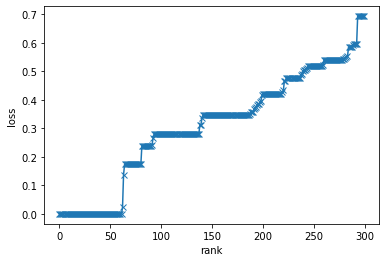

In [32]:
plt.xlabel("rank")
plt.ylabel("loss")
plt.plot(np.sort(res),"x-")

I try with a deeper architecture

In [33]:
res=[]
par=[]
np.random.seed(1977)
for i in range(300):
    ann=ANN([3,3,3],random_weights=True)
    m=minimize(function,ann.getpar(),args=(ann,data,labels),jac=True,method='L-BFGS-B')
    res.append(m.fun)
    par.append(m.x)

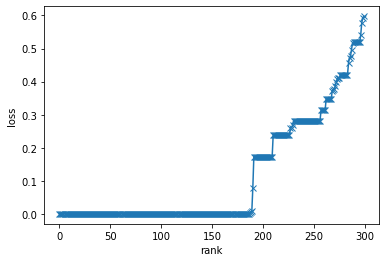

In [34]:
plt.xlabel("rank")
plt.ylabel("loss")
plt.plot(np.sort(res),"x-")

The fraction of cases in which I am able to make a perfect classifier seems higher. Not sure how this is general.

I then try with an even larger input.

In [35]:
data=enumerate_data(6)
labels=xor(data)
to_pandas(data,labels)

,v1,v2,v3,v4,v5,v6,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
59,1.0,1.0,1.0,0.0,1.0,1.0,1.0
60,1.0,1.0,1.0,1.0,0.0,0.0,0.0
61,1.0,1.0,1.0,1.0,0.0,1.0,1.0
62,1.0,1.0,1.0,1.0,1.0,0.0,1.0


In [36]:
res=[]
par=[]
np.random.seed(1977)
for i in range(300):
    ann=ANN([6,6],random_weights=True)
    m=minimize(function,ann.getpar(),args=(ann,data,labels),jac=True,method='L-BFGS-B')
    res.append(m.fun)
    par.append(m.x)

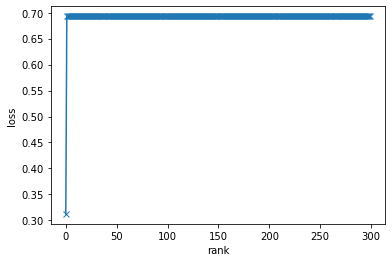

In [37]:
plt.xlabel("rank")
plt.ylabel("loss")

plt.plot(np.sort(res),"x-")

In [38]:
ann.setpar(par[np.argmin(res)])
confusion_matrix(xor(data),ann.applyVec(data))

confusion matrix:
TP 26
FP 1
FN 6
TN 31
MCC 0.7909649964604158


Not bad, but it happens rarely (once in 300 attempts!)

# Limited dataset
I then try to train the network with a limited number of examples. Here 8 over `2**3=8` possible states

In [39]:
np.random.seed(1977)
data=random_data(3,8)
labels=xor(data)
to_pandas(data,labels)

,v1,v2,v3,label
0,1.0,1.0,0.0,0.0
1,0.0,1.0,1.0,0.0
2,1.0,1.0,0.0,0.0
3,0.0,1.0,0.0,1.0
4,0.0,1.0,1.0,0.0
5,1.0,0.0,1.0,0.0
6,1.0,1.0,1.0,1.0
7,1.0,0.0,0.0,1.0


In [40]:
validation_data=random_data(3,20)
validation_labels=xor(validation_data)

In [41]:
par=[]
for i in range(300):
    ann=ANN([3,3],random_weights=True)
    m=minimize(function,ann.getpar(),args=(ann,data,labels),jac=True,method='L-BFGS-B')
    par.append(m.x)


In [42]:
training=[]
validation=[]
training_MCC=[]
validation_MCC=[]
for p in par:
    ann.setpar(p)
    training.append(np.average(softplus(ann.applyVec(data)*(1-2*labels))))
    validation.append(np.average(softplus(ann.applyVec(validation_data)*(1-2*validation_labels))))
    training_MCC.append(MCC(labels,ann.applyVec(data)))
    validation_MCC.append(MCC(validation_labels,ann.applyVec(validation_data)))

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


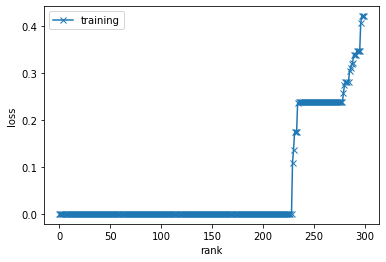

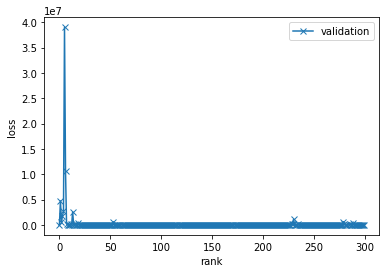

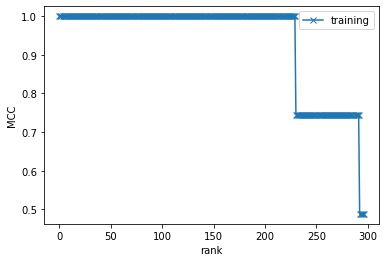

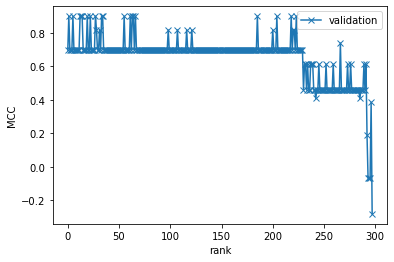

In [43]:
plt.xlabel("rank")
plt.ylabel("loss")
plt.plot(np.sort(training),"x-",label="training")
plt.legend()
plt.show()

plt.xlabel("rank")
plt.ylabel("loss")
plt.plot(np.array(validation)[np.argsort(training)],"x-",label="validation")
plt.legend()
plt.show()

plt.xlabel("rank")
plt.ylabel("MCC")
plt.plot(np.array(training_MCC)[np.argsort(training)],"x-",label="training")
plt.legend()
plt.show()

plt.xlabel("rank")
plt.ylabel("MCC")
plt.plot(np.array(validation_MCC)[np.argsort(training)],"x-",label="validation")
plt.legend()
plt.show()

Even though validation loss function is very large, MCC is good, even though not perfect!

Now with more examples

In [44]:
np.random.seed(1977)
data=random_data(3,24)
labels=xor(data)
validation_data=random_data(3,20)
validation_labels=xor(validation_data)
par=[]
for i in range(300):
    ann=ANN([3,3],random_weights=True)
    m=minimize(function,ann.getpar(),args=(ann,data,labels),jac=True,method='L-BFGS-B')
    par.append(m.x)

In [45]:
training=[]
validation=[]
training_MCC=[]
validation_MCC=[]
for p in par:
    ann.setpar(p)
    training.append(np.average(softplus(ann.applyVec(data)*(1-2*labels))))
    validation.append(np.average(softplus(ann.applyVec(validation_data)*(1-2*validation_labels))))
    training_MCC.append(MCC(labels,ann.applyVec(data)))
    validation_MCC.append(MCC(validation_labels,ann.applyVec(validation_data)))

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


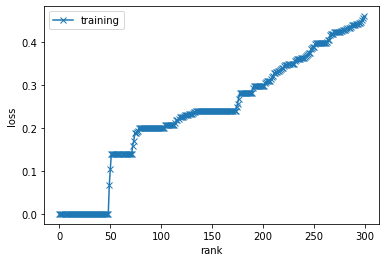

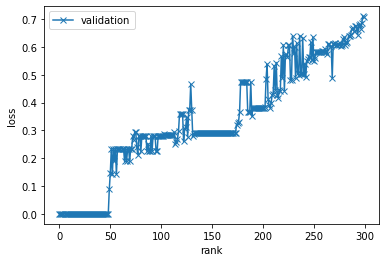

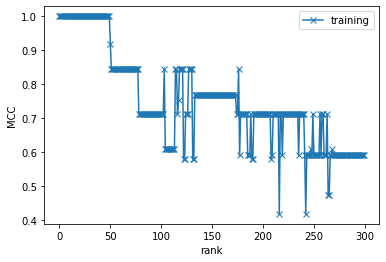

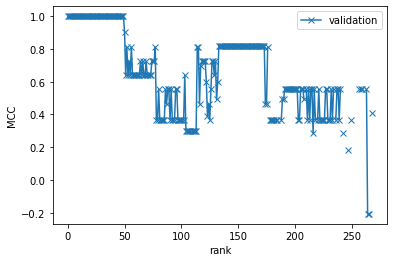

In [46]:
plt.xlabel("rank")
plt.ylabel("loss")
plt.plot(np.sort(training),"x-",label="training")
plt.legend()
plt.show()

plt.xlabel("rank")
plt.ylabel("loss")
plt.plot(np.array(validation)[np.argsort(training)],"x-",label="validation")
plt.legend()
plt.show()

plt.xlabel("rank")
plt.ylabel("MCC")
plt.plot(np.array(training_MCC)[np.argsort(training)],"x-",label="training")
plt.legend()
plt.show()

plt.xlabel("rank")
plt.ylabel("MCC")
plt.plot(np.array(validation_MCC)[np.argsort(training)],"x-",label="validation")
plt.legend()
plt.show()

This is definitely ok.

Now a larger system. 64 examples on `2**6`=64 possible states.

In [47]:
np.random.seed(1977)
data=random_data(6,64)
labels=xor(data)
validation_data=random_data(6,64)
validation_labels=xor(validation_data)
par=[]
for i in range(300):
    ann=ANN([6,6],random_weights=True)
    m=minimize(function,ann.getpar(),args=(ann,data,labels),jac=True,method='L-BFGS-B')
    ann.setpar(m.x)
    par.append(m.x)


In [48]:
training=[]
validation=[]
training_MCC=[]
validation_MCC=[]
for p in par:
    ann.setpar(p)
    training.append(np.average(softplus(ann.applyVec(data)*(1-2*labels))))
    validation.append(np.average(softplus(ann.applyVec(validation_data)*(1-2*validation_labels))))
    training_MCC.append(MCC(labels,ann.applyVec(data)))
    validation_MCC.append(MCC(validation_labels,ann.applyVec(validation_data)))

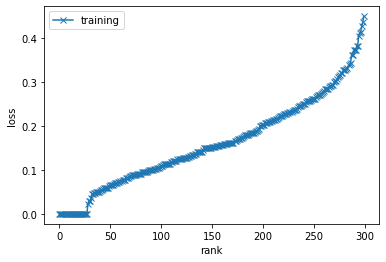

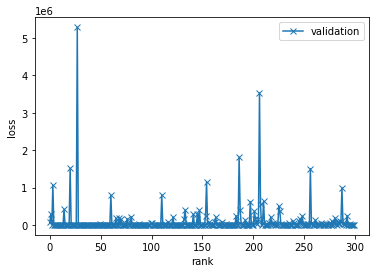

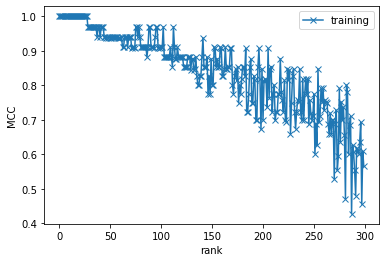

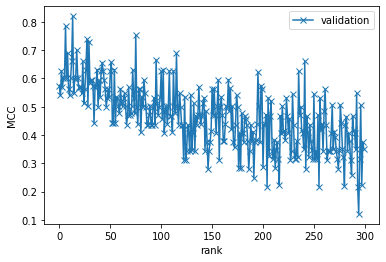

In [49]:
plt.xlabel("rank")
plt.ylabel("loss")
plt.plot(np.sort(training),"x-",label="training")
plt.legend()
plt.show()

plt.xlabel("rank")
plt.ylabel("loss")
plt.plot(np.array(validation)[np.argsort(training)],"x-",label="validation")
plt.legend()
plt.show()

plt.xlabel("rank")
plt.ylabel("MCC")
plt.plot(np.array(training_MCC)[np.argsort(training)],"x-",label="training")
plt.legend()
plt.show()

plt.xlabel("rank")
plt.ylabel("MCC")
plt.plot(np.array(validation_MCC)[np.argsort(training)],"x-",label="validation")
plt.legend()
plt.show()